### Helpful resources

- https://notebook.community/NeuroStat/Python-scripts/python_scripts_day1/day2_func_conn
- https://lukas-snoek.com/NI-edu/fMRI-introduction/week_7/nilearn.html

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys
from os.path import exists

import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil

from nilearn import plotting
from nilearn.plotting import find_xyz_cut_coords, plot_connectome, view_img
from nilearn.glm import cluster_level_inference
from nilearn.image import binarize_img, new_img_like, mean_img, math_img

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(0, '/Users/matty_gee/Dropbox/Projects/toolbox/toolbox')
from images import save_as_nifti

# GM/WM masks

### Combine GM & WM masks
- Exclude non brain, csf

In [3]:
# # resample
# mask_dir = '/Volumes/synapse/projects/SocialSpace/Masks'
# wm_img = nib.load(mask_dir + '/SPM_TPM_WM_thr25.nii')
# gm_img = nib.load(mask_dir + '/SPM_TPM_GM_thr25.nii')
# dims, vox_size, affine = get_nifti_info(gm_img)

# # combine
# combined_img = ((gm_img.get_fdata() + wm_img.get_fdata()) > 0) * 1
# save_as_nifti(combined_img, mask_dir + '/SPM_TPM_GM+WM_thr25.nii', affine, vox_size)

# # resample
# combined_img_resampled = nl.image.resample_to_img(mask_dir + '/SPM_TPM_GM+WM_thr25.nii', 
#                                                   sample_img_dict['Main']['example_img'], interpolation='nearest') 
# combined_img_resampled = (combined_img_resampled.get_fdata() > 0) * 1
# save_as_nifti(combined_img_resampled, mask_dir + '/Main_SPM_TPM_GM+WM_thr25.nii', 
#               sample_img_dict['Main']['affine'], 
#               sample_img_dict['Main']['vox_size'])                                                

# brain_mask = nib.load('masks/Main_SPM_TPM_GM+WM_thr25.nii').get_fdata()
# sub_mask = nib.load('/Volumes/synapse/projects/SocialSpace/Projects/2D_place/Samples/Main/GLMs_FAST_mask50/Glms/18001_HC_xnat100532632/mask.nii').get_fdata()
# brain_mask = sub_mask * brain_mask
# brain_nii = nib.Nifti1Image(brain_mask, sample_img_dict['Main']['affine'])

### Make GM mask for all subjects

In [2]:
# glm_fnames = []
# for sample, s in {'Original': 0, 'Replication': 1}.items():
#     glm_path = '/Volumes/synapse/projects/SocialSpace/Projects/2D_place/Samples/' + sample + '/GLMs_FAST_mask50/Glms'
#     if sample == 'Original':
#         glm_fname = 'beta_4d_resampled.nii'
#     else:
#         glm_fname = 'beta_4d.nii'
        
#     for sub_dir in glob.glob(glm_path + '/*'):
#         if sub_dir.split('/')[-1].split('_')[0] not in excl:
#             glm_fnames.append(sub_dir + '/' + glm_fname)
        
# print(f'Found {len(glm_fnames)} subjects')

# gm_mask = nilearn.masking.compute_multi_brain_mask(glm_fnames, mask_type='gm', threshold=0.25, connected=False)
# plotting.plot_roi(gm_mask)
# # gm_mask.to_filename('../../Masks/All-subjs_gm_thr25.nii')

# Hippocampus masks

### Combine hemispheres

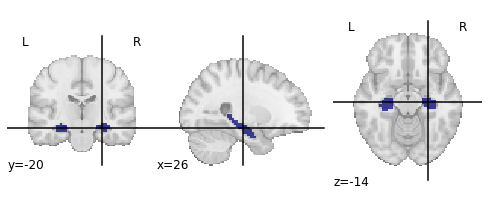

In [24]:
l_fname = '../../Masks/Orig_L_HPC_harvardoxford_maxprob-thr50-1mm.nii'
r_fname = '../../Masks/Orig_R_HPC_harvardoxford_maxprob-thr50-1mm.nii'
bilateral_img = nilearn.masking.intersect_masks([l_fname, r_fname], threshold=0, connected=False) # union of two masks
plotting.plot_roi(bilateral_img) 
bilateral_img.to_filename('../../Masks/Orig_bilateral_HPC_harvardoxford_maxprob-thr50-1mm.nii')

### Split hemispheres

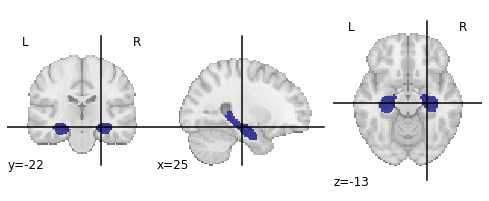

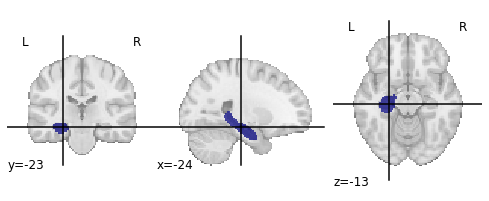

In [24]:
bilateral_fname = '../../Masks/Repl_bilateral_HPC_harvardoxford_maxprob-thr10-1mm.nii'
plotting.plot_roi(bilateral_fname)
bilateral_data = nib.load(bilateral_fname).get_fdata()

# make a left hemisphere roi
bilateral_data[0:38,:,:] = 0
affine_mat = sample_img_dict['Validation']['affine']
vox_size = sample_img_dict['Validation']['vox_size']
plotting.plot_roi(nib.Nifti1Image(bilateral_data, affine_mat))
save_as_nifti(bilateral_data, '../../Masks/Repl_L_HPC_harvardoxford_maxprob-thr10-1mm.nii', affine_mat, vox_size)

### Anterior, mid, posterior
#### Intersect block masks with hippocampal masks to generate sub-sections

* created the block masks in marsbar in matlab

"we split the hippocampal mask in approximately equally long parts along the long axis (posterior portion of the hippocampus: from Y = −40 to −30; mid-portion of the hippocampus: from Y = −29 to −19; anterior portion of the hippocampus: from Y = −18 to −4) for the left and right side"


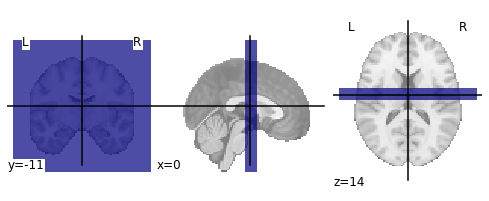

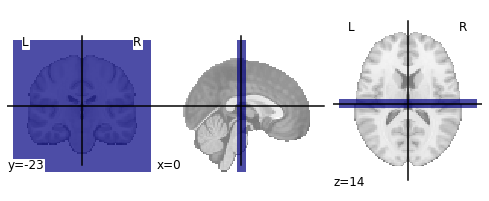

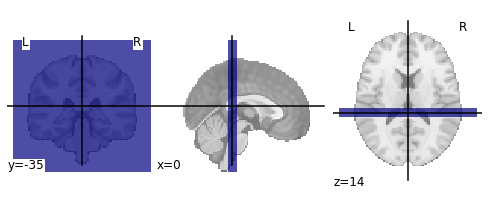

In [30]:
hpc_segments = {'ant': 'HPC_ant_box_y-18to-3_roi.nii',
                'mid': 'HPC_mid_box_y-29to-18_roi.nii',
                'post': 'HPC_post_box_y-40to-29_roi.nii'} 
for segment, mask in hpc_segments.items():
    plotting.plot_roi('../../Masks/' + mask)

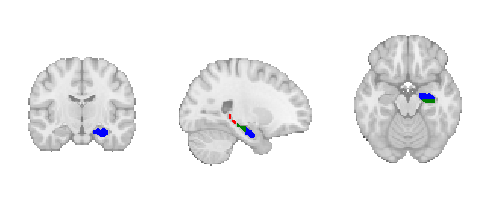

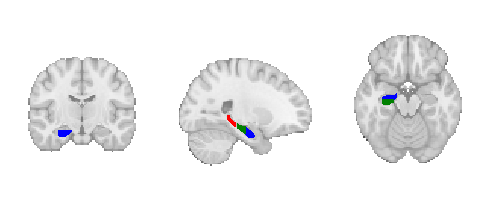

In [35]:
# intersects the diff part blocks with whole hip masks, for both samples

mask_info = 'maxprob-thr50-1mm'
for h in ['R','L']:
    for sample in ['Repl']:
        for part in ['post','mid','ant']:
            
            # intersection of part w/ existing whole hip mask
            hpc_fname  = '../../Masks/' + sample + '_' + h + '_HPC_harvardoxford_' + mask_info + '.nii' 
            part_fname = '../../Masks/' + hpc_segments[part] 
            resampled_part = resample_to_nifti(part_fname, hpc_fname, interpolation='nearest') # resample block to the hippocampal mask
            part_img = nilearn.masking.intersect_masks([hpc_fname, resampled_part], threshold=1, connected=False) # union of two masks
            nib.save(part_img, '../../Masks/' + sample + '_' + h + '_HPC_' + part + '_harvardoxford_' + mask_info + '.nii')

        # display all parts
        if h == 'R': 
            x=24
        else: 
            x=-24
        overlap = plotting.plot_anat(display_mode='ortho', cut_coords=[x,-14,-18], draw_cross=False, annotate=False)
        overlap.add_contours('../../Masks/' + sample + '_' + h + '_HPC_ant_harvardoxford_' + mask_info + '.nii' , linewidth=0.5, filled=True, colors='blue') 
        overlap.add_contours('../../Masks/' + sample + '_' + h + '_HPC_mid_harvardoxford_' + mask_info + '.nii' , linewidth=0.5, filled=True, colors='green') 
        overlap.add_contours('../../Masks/' + sample + '_' + h + '_HPC_post_harvardoxford_' + mask_info + '.nii' , linewidth=0.5, filled=True, colors='red') 

# Atlas-based ROIs

In [4]:
atlas_dir = 'Masks/HarvardOxford'
mask_info = 'maxprob-thr25-1mm'

## harvard oxford
print('downloading Harvard Oxford ' + mask_info)

# cortical
ho_cort_atlas = nil.datasets.fetch_atlas_harvard_oxford('cort-' + mask_info, data_dir=atlas_dir, symmetric_split=True, resume=True, verbose=0)
ho_cort_atlas_img = ho_cort_atlas.maps
ho_cort_atlas_affine = ho_cort_atlas_img.get_affine()
ho_cort_atlas_data = ho_cort_atlas_img.get_data()

# # 23 subcortical regions:
# ho_sub_atlas = nil.datasets.fetch_atlas_harvard_oxford('sub-' + mask_info, data_dir=atlas_dir, symmetric_split=True, resume=True, verbose=0)
# ho_sub_atlas_img = ho_sub_atlas.maps
# ho_sub_atlas_affine = ho_sub_atlas_img.get_affine()
# ho_sub_atlas_data = ho_sub_atlas_img.get_data()
    
## juelich   
# print('downloading Juelich ' + mask_info)
# ju_atlas = nil.datasets.fetch_atlas_juelich(mask_info, data_dir=atlas_dir,  symmetric_split=True, resume=True, verbose=0)
# ju_atlas_img = nib.load(ju_atlas.maps)
# ju_atlas_affine = ju_atlas_img.get_affine()
# ju_atlas_data = ju_atlas_img.get_data()

downloading Harvard Oxford maxprob-thr25-1mm


In [8]:
ho_cort_regions = ho_cort_atlas['labels'][1:]
ho_cort_regions
# [c for c in ho_cort_regions if 'cuneus' in c]

['Left Frontal Pole',
 'Right Frontal Pole',
 'Left Insular Cortex',
 'Right Insular Cortex',
 'Left Superior Frontal Gyrus',
 'Right Superior Frontal Gyrus',
 'Left Middle Frontal Gyrus',
 'Right Middle Frontal Gyrus',
 'Left Inferior Frontal Gyrus, pars triangularis',
 'Right Inferior Frontal Gyrus, pars triangularis',
 'Left Inferior Frontal Gyrus, pars opercularis',
 'Right Inferior Frontal Gyrus, pars opercularis',
 'Left Precentral Gyrus',
 'Right Precentral Gyrus',
 'Left Temporal Pole',
 'Right Temporal Pole',
 'Left Superior Temporal Gyrus, anterior division',
 'Right Superior Temporal Gyrus, anterior division',
 'Left Superior Temporal Gyrus, posterior division',
 'Right Superior Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, anterior division',
 'Right Middle Temporal Gyrus, anterior division',
 'Left Middle Temporal Gyrus, posterior division',
 'Right Middle Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, temporooccipital part',
 'Righ


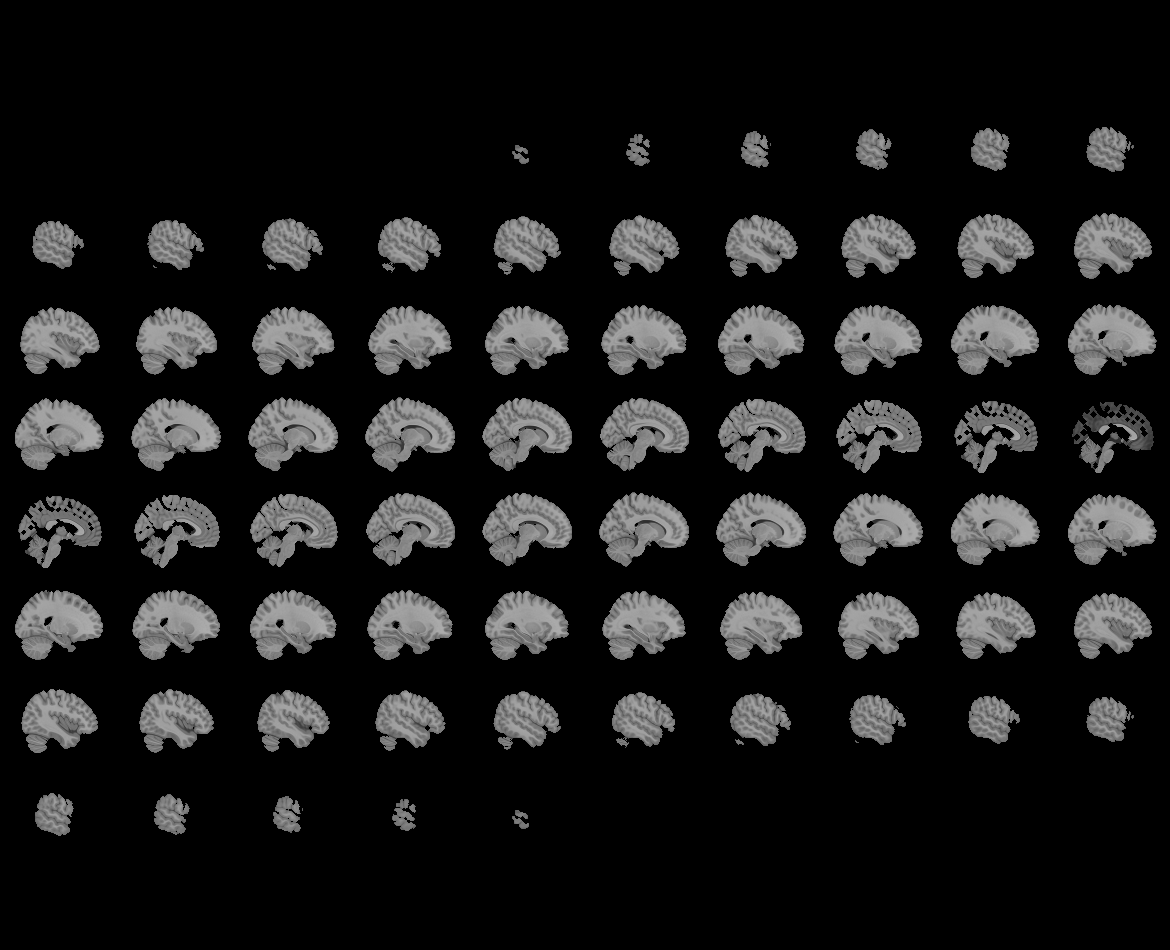
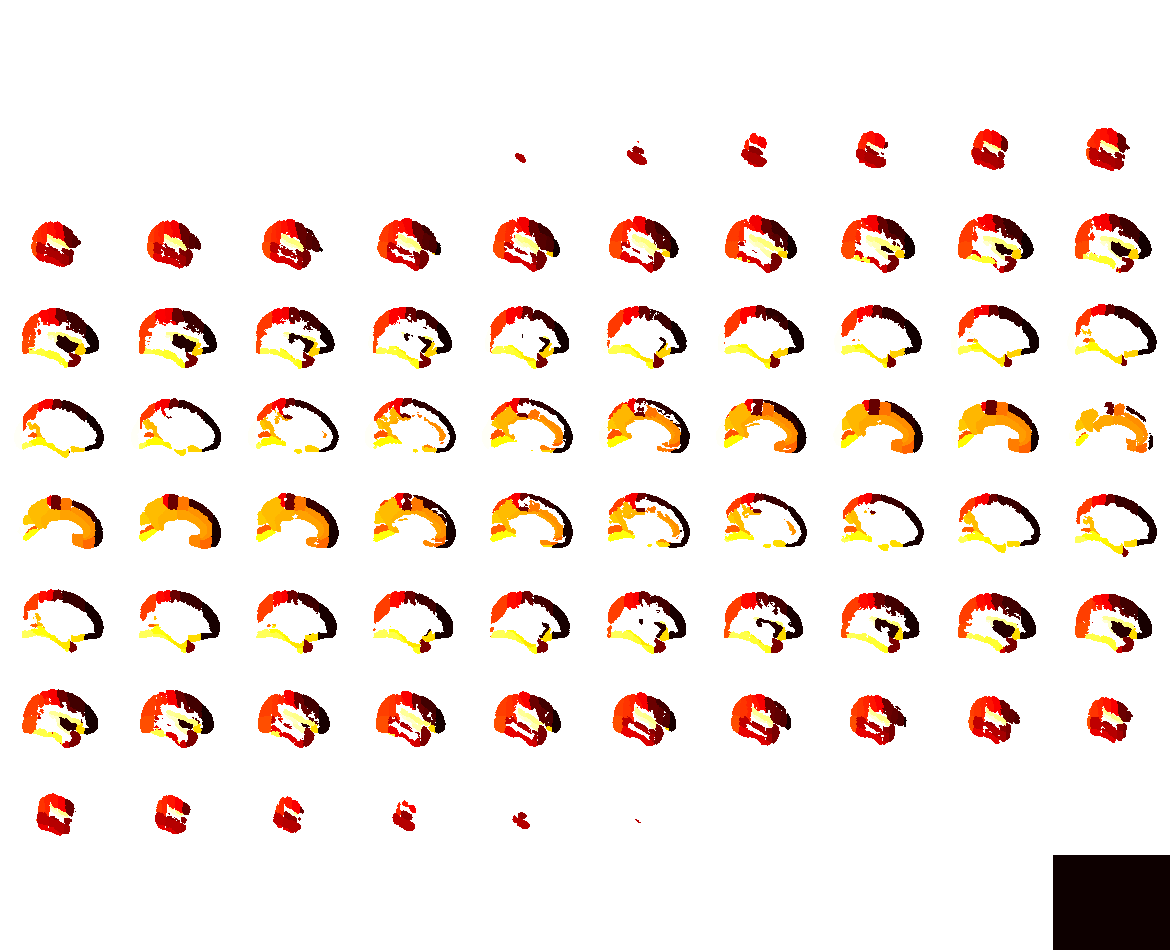

In [10]:
plotting.view_img(ho_cort_atlas['filename'], title="Harvard Oxford atlas")

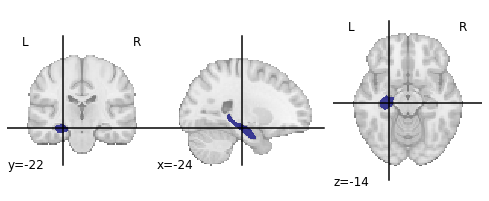

In [74]:
## for roi_name, label in roi_label_dict.items():
roi_ix = np.where(np.array(ho_sub_atlas.labels)=='Left Hippocampus')
roi_img = new_img_like(ho_sub_atlas_img, (ho_sub_atlas_data == roi_ix).astype(int), ho_cort_atlas_affine)
save_as_nifti(frontal_data, '../Masks/L-HPC_havardoxford_' + mask_info + '.nii', affine_matrix, vox_size)

plotting.plot_roi(roi_img)

# Neurosynth maps
https://nilearn.github.io/auto_examples/06_manipulating_images/plot_roi_extraction.html

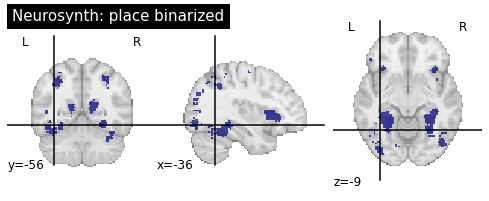

In [5]:
# binarize
neurosynth_fname  = '../../Masks/neurosynth/neurosynth_place_uniformity-test_z_FDR_0.01.nii.gz'
binarized_img = nilearn.image.binarize_img(neurosynth_fname, threshold=0) # keep anything not 0
plotting.plot_roi(binarized_img, title='Neurosynth: place binarized')
# nib.save(binarized_img, '../../Masks/neurosynth/neurosynth_place_uniformity-test_z_FDR_0.01_binarized.nii.gz')

### Eroded

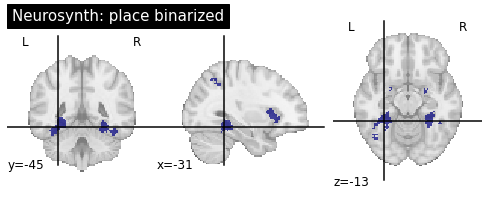

In [20]:
data_eroded = ndimage.binary_erosion(binarized_img.get_fdata(), iterations=1).astype(np.int)
binarized_img_eroded = new_img_like(binarized_img, data_eroded)
plotting.plot_roi(binarized_img_eroded, title='Neurosynth: place binarized')
nib.save(binarized_img_eroded, '../../Masks/neurosynth/neurosynth_place_uniformity-test_z_FDR_0.01_binarized_eroded.nii.gz')

### Dilated

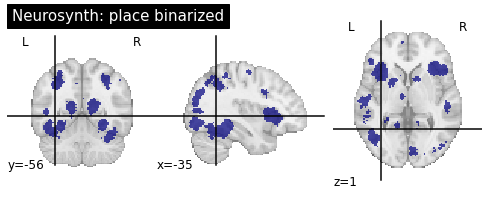

In [21]:
data_dilated = ndimage.binary_dilation(binarized_img.get_fdata(), iterations=1).astype(np.int)
binarized_img_dilated = new_img_like(binarized_img, data_dilated)
plotting.plot_roi(binarized_img_dilated, title='Neurosynth: place binarized')
nib.save(binarized_img_dilated, '../../Masks/neurosynth/neurosynth_place_uniformity-test_z_FDR_0.01_binarized_dilated.nii.gz')

### Turned into an atlas

In [56]:
def atlasify_map(map_img, binarize_thr=None, erosion_iter=None, dilation_iter=None, extent_thr=0):

    if binarize_thr is not None:
        map_img = math_img('img > ' + str(binarize_thr), img=map_img)
    data = map_img.get_fdata()
    if erosion_iter is not None:
        data = ndimage.binary_erosion(data, iterations=erosion_iter).astype(np.int) # erode the clusters: get rid of random voxels
    if dilation_iter is not None:
        data = ndimage.binary_dilation(data, iterations=dilation_iter).astype(np.int) # dilate the clusters: make bigger
    labeled_data, n_labels = ndimage.label(data) # get clusters labeled with integers
    labeled_img = new_img_like(map_img, labeled_data)
    print(f'Found {n_labels} clusters in map.')

    # should try to speed this up somehow
    c = 0
    atlas_imgs = []
    for n in range(1, n_labels):
        cluster_data = (labeled_data == n).astype(np.int)
        voxel_count = np.sum(cluster_data)
        if voxel_count > extent_thr: 
            c += 1
            atlas_data = np.expand_dims(cluster_data, axis=3)
            # if c == 1: 
            #     atlas_data = np.expand_dims(cluster_data, axis=3)
            # else: 
            #     atlas_data = np.concatenate((atlas_data, np.expand_dims(cluster_data, axis=3)), axis=3)
            atlas_imgs.append(new_img_like(map_img, atlas_data[:,:,:,0]))
    print(f'{c} clusters survived (optional) erosion and voxel extent thresholding.')

    for i, img in enumerate(atlas_imgs):
        plotting.plot_roi(img)
    
    return atlas_imgs, labeled_img


Found 5 clusters in map.
4 clusters survived (optional) erosion and voxel extent thresholding.


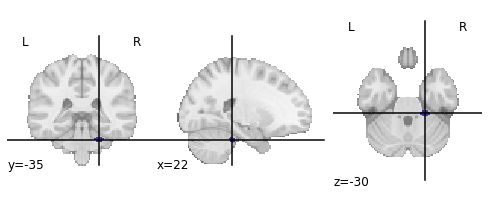

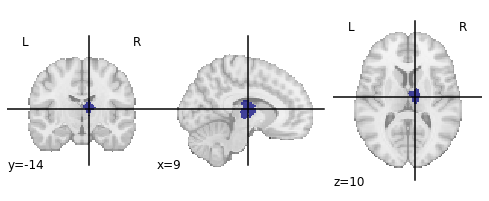

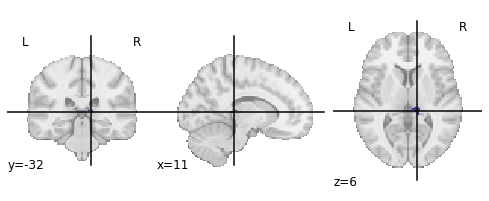

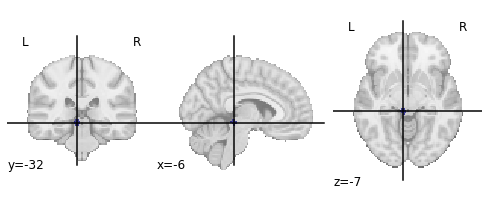

In [59]:
map_img = nib.load('../../Masks/Sl_2d-place_3-voxel-ball_0.2_Combined_smoothed2.1_combined-gm50_tfce_resampled_p0.05_binarized.nii')
atlas_imgs, labeled_img = atlasify_map(map_img, binarize_thr=0, erosion_iter=None, dilation_iter=1, extent_thr=8)

In [58]:
atlas_imgs[0].to_filename('../../Masks/Sl_R_thalamus.nii')
atlas_imgs[1].to_filename('../../Masks/Sl_L_HPC_ant.nii')

In [60]:
# map_img = nib.load('../../Masks/neurosynth/neurosynth_place_uniformity-test_z_FDR_0.01.nii.gz')
# atlas_imgs, labeled_img = atlasify_map(map_img, binarize_thr=0, erosion_iter=1, dilation_iter=1, extent_thr=50)
# # plotting.view_img(labeled_img)
# nib.save(labeled_img, '../../Masks/neurosynth/neurosynth_place_uniformity-test_z_FDR_0.01_binarized_atlas_17clusters.nii.gz')

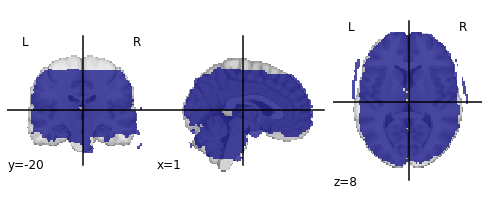

In [66]:
resampled_img = nib.load('/Volumes/synapse/projects/SocialSpace/Projects/2D_place/Samples/Original/GLMs_FAST_mask50/Glms/01/mask_resampled.nii')
plotting.plot_roi(resampled_img)

In [61]:
%run -i 'Run_roi_masker.py'

Running 01
Running 02
Running 03
Running 05
Running 06
Running 07
Running 08
Running 09
Running 10
Running 11
Running 12
Running 14
Running 15
Running 16
Running 17
Running 18
Running 19
Running 20
Running 21
Running 18005
Running 18010
Running 18007
Running 21020
Running 22001
Running 18009
Running 22004
Running 22009
Running 21015
Running 21011
Running 21012
Running 21014
Running 21003
Running 21009
Running 21008
Running 21002
Running 18001
Running 18002
Running 18003
Running 18013
Running 18011
Running 20009
Running 20008
Running 20006
Running 20004
Running 20005
Running 20003
Running 20002
Running 19059
Running 19037
Running 19033
Running 19035
Running 18017
Running 18018
Running 19002
Running 19003
Running 19031
Running 19032
Running 19005
Running 19030


<Figure size 432x288 with 0 Axes>